# Rice Yield Prediction: PyTorch LSTM with Optuna Tuning

## Overview
This notebook trains a **Long Short-Term Memory (LSTM)** network using **PyTorch** to predict Rice yields. 

## Methodology
1.  **Data Setup:** Loading parquet data and splitting by year.
2.  **Preprocessing:** Imputing missing values and Standard Scaling. 
    * *Note:* For LSTM, we reshape the input to be **(Batch, Sequence, Features)**. Since the previous workflow treated samples independently, we use a Sequence Length of 1 to maintain strict compatibility with the existing data splits.
3.  **PyTorch Setup:** Converting data to Tensors and creating DataLoaders.
4.  **Baseline:** Naive approach (Last Year's Yield).
5.  **Initial Model:** Defining an `nn.LSTM` based regressor and training with a custom loop.
6.  **Optimization:** Using **Optuna** to find the best LSTM architecture (Hidden Size, Layers, Dropout, LR).
7.  **Final Evaluation:** Retraining on full data and comparing performance.

In [1]:
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance

# PyTorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Optuna Visualization Tools
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_slice
from optuna.visualization import plot_param_importances

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

/Users/pavin/Documents/GitHub/ML_project/.venv-1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


### 1. Data Loading & Feature Selection

In [2]:
# Load dataset
df = pd.read_parquet('Parquet/XY_version1.parquet')

# Define Target
TARGET_COL = 'Y_rice'
LAG_1_FEATURE = 'avg_yield_rice_1y'

# Clean Missing Targets
df_model = df.dropna(subset=[TARGET_COL])

# Select Features
feature_cols = [c for c in df_model.columns if not c.startswith('Y_') and c not in ['year', 'area']]

print(f"Data Loaded. Features: {len(feature_cols)}")

Data Loaded. Features: 67


### 2. Preprocessing & Tensor Conversion
We split by year, scale the data, and convert to **3D Tensors** `(Batch, Seq_Len=1, Features)` for the LSTM.

In [3]:
# --- TIME-SERIES SPLIT ---
TRAIN_END_YEAR = 2016
VAL_END_YEAR = 2020

# 1. Create Masks
mask_train = df_model['year'] < TRAIN_END_YEAR
mask_val = (df_model['year'] >= TRAIN_END_YEAR) & (df_model['year'] < VAL_END_YEAR)
mask_test = df_model['year'] >= VAL_END_YEAR

# 2. Split Dataframes
X_train_raw = df_model[mask_train][feature_cols]
y_train_raw = df_model[mask_train][TARGET_COL].values.reshape(-1, 1)

X_val_raw = df_model[mask_val][feature_cols]
y_val_raw = df_model[mask_val][TARGET_COL].values.reshape(-1, 1)

X_test_raw = df_model[mask_test][feature_cols]
y_test_raw = df_model[mask_test][TARGET_COL].values.reshape(-1, 1)

# --- SKLEARN PREPROCESSING ---
print("Imputing and Scaling...")
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()

# Pipe: Train -> Val -> Test
X_train_np = scaler.fit_transform(imputer.fit_transform(X_train_raw))
X_val_np = scaler.transform(imputer.transform(X_val_raw))
X_test_np = scaler.transform(imputer.transform(X_test_raw))

# --- PYTORCH TENSORS (LSTM Shape Adaptation) ---
def to_lstm_tensor(X, y, device):
    # LSTM expects (Batch, Seq_Len, Features)
    # We use Seq_Len = 1 for compatibility with non-sequence row data
    X_t = torch.tensor(X, dtype=torch.float32).unsqueeze(1).to(device)
    y_t = torch.tensor(y, dtype=torch.float32).to(device)
    return X_t, y_t

X_train_t, y_train_t = to_lstm_tensor(X_train_np, y_train_raw, device)
X_val_t, y_val_t = to_lstm_tensor(X_val_np, y_val_raw, device)
X_test_t, y_test_t = to_lstm_tensor(X_test_np, y_test_raw, device)

print(f"Training Tensor Shape: {X_train_t.shape}")

Imputing and Scaling...
Training Tensor Shape: torch.Size([3676, 1, 67])


### 3. Baseline Model
Calculating performance if we simply predicted "Last Year's Yield".

In [4]:
# Baseline: yield(t) = yield(t-1)
y_pred_baseline = df_model[mask_test][LAG_1_FEATURE]

# Clean NaNs for metric calculation
mask_valid = ~y_pred_baseline.isna() & ~np.isnan(y_test_raw.flatten())
y_test_clean = y_test_raw.flatten()[mask_valid]
y_pred_clean = y_pred_baseline[mask_valid]

rmse_baseline = np.sqrt(mean_squared_error(y_test_clean, y_pred_clean))
r2_baseline = r2_score(y_test_clean, y_pred_clean)

print(f"Baseline RMSE: {rmse_baseline:.2f}")

Baseline RMSE: 527.17


### 4. LSTM Model Definition & Training Loop
We define a `RiceYieldLSTM` and a reusable training function.

Training Initial LSTM Model...


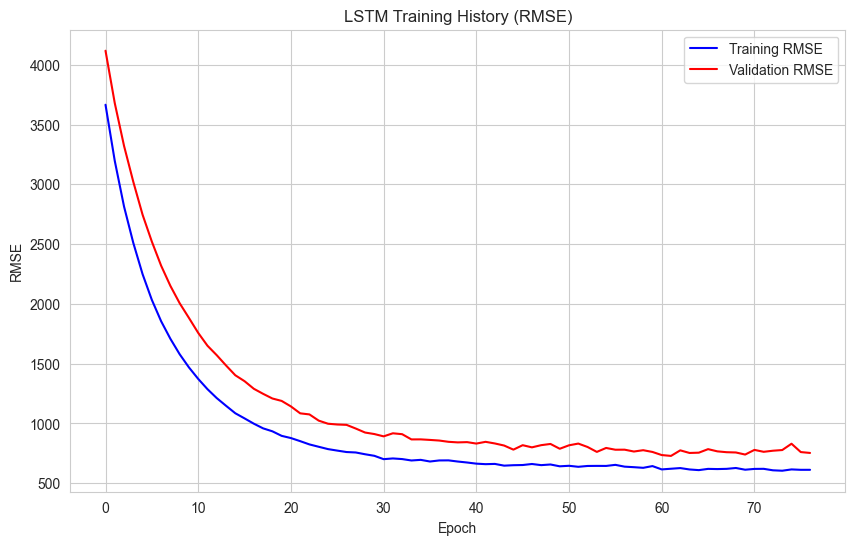

Initial Model Test RMSE: 913.91


In [9]:
# --- LSTM ARCHITECTURE ---
class RiceYieldLSTM(nn.Module):
    def __init__(self, input_dim, hidden_size=64, n_layers=2, dropout=0.1):
        super(RiceYieldLSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        # LSTM Layer
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_size,
            num_layers=n_layers,
            batch_first=True,
            dropout=dropout if n_layers > 1 else 0.0
        )
        
        # Fully Connected Output Layer
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x shape: (batch, seq_len, features)
        # h0, c0 initialized to 0 by default
        out, (hn, cn) = self.lstm(x)
        
        # We take the output from the last time step
        # out shape: (batch, seq_len, hidden_size)
        out = out[:, -1, :]
        
        out = self.fc(out)
        return out

# --- TRAINING HELPER FUNCTION ---
def train_model(model, train_loader, X_val, y_val, epochs=150, lr=0.1, patience=15):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    history = {'train_loss': [], 'val_loss': []}
    best_val_loss = float('inf')
    patience_counter = 0
    best_weights = None
    
    for epoch in range(epochs):
        model.train()
        batch_losses = []
        
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
            
        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val).item()
            
        avg_train_loss = np.mean(batch_losses)
        
        # Store history (RMSE)
        history['train_loss'].append(np.sqrt(avg_train_loss))
        history['val_loss'].append(np.sqrt(val_loss))
        
        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_weights = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            break
            
    # Restore best model
    if best_weights:
        model.load_state_dict(best_weights)
        
    return history

# --- INITIAL TRAINING ---
train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Initialize LSTM
model_init = RiceYieldLSTM(input_dim=X_train_t.shape[2], hidden_size=64, n_layers=2).to(device)

print("Training Initial LSTM Model...")
history = train_model(model_init, train_loader, X_val_t, y_val_t, epochs=150, patience=15)

# Plot History
plt.figure(figsize=(10, 6))
plt.plot(history['train_loss'], label='Training RMSE', color='blue')
plt.plot(history['val_loss'], label='Validation RMSE', color='red')
plt.title('LSTM Training History (RMSE)')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Evaluation
model_init.eval()
with torch.no_grad():
    y_pred_init = model_init(X_test_t).cpu().numpy()

rmse_init = np.sqrt(mean_squared_error(y_test_raw, y_pred_init))
print(f"Initial Model Test RMSE: {rmse_init:.2f}")

### 5. Optuna Hyperparameter Optimization
We optimize LSTM-specific parameters: hidden size, layers, dropout, learning rate.

In [15]:
# --- OPTUNA OBJECTIVE ---
def objective(trial):
    # Suggest Params
    hidden_size = trial.suggest_int('hidden_size', 32, 256, step=32)
    n_layers = trial.suggest_int('n_layers', 1, 3)
    dropout = trial.suggest_float('dropout', 0.0, 0.3)
    lr = trial.suggest_float('learning_rate', 0.01, 1, log=True)
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32, 64])
    
    # Data Loader
    dataset = TensorDataset(X_train_t, y_train_t)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Initialize Model
    model = RiceYieldLSTM(
        input_dim=X_train_t.shape[2],
        hidden_size=hidden_size,
        n_layers=n_layers,
        dropout=dropout
    ).to(device)
    
    # Train
    train_model(model, loader, X_val_t, y_val_t, epochs=100, lr=lr, patience=10)
    
    # Validate
    model.eval()
    with torch.no_grad():
        preds = model(X_val_t).cpu().numpy()
    
    rmse = np.sqrt(mean_squared_error(y_val_raw, preds))
    return rmse

# --- RUN OPTIMIZATION ---
study = optuna.create_study(direction='minimize', study_name='Rice_Yield_LSTM')
study.optimize(objective, n_trials=10)

print("\nBest Parameters found:")
print(study.best_params)

[I 2025-11-26 21:41:26,891] A new study created in memory with name: Rice_Yield_LSTM
[I 2025-11-26 21:41:52,347] Trial 0 finished with value: 997.6776689738901 and parameters: {'hidden_size': 224, 'n_layers': 2, 'dropout': 0.1286433093509367, 'learning_rate': 0.3896842333664337, 'batch_size': 8}. Best is trial 0 with value: 997.6776689738901.
[I 2025-11-26 21:41:54,648] Trial 1 finished with value: 884.4484890914664 and parameters: {'hidden_size': 128, 'n_layers': 2, 'dropout': 0.031774551806287986, 'learning_rate': 0.4587432870234613, 'batch_size': 64}. Best is trial 1 with value: 884.4484890914664.
[I 2025-11-26 21:42:11,610] Trial 2 finished with value: 751.4992241629051 and parameters: {'hidden_size': 224, 'n_layers': 2, 'dropout': 0.1377968120735677, 'learning_rate': 0.1166823504324508, 'batch_size': 16}. Best is trial 2 with value: 751.4992241629051.
[I 2025-11-26 21:42:26,439] Trial 3 finished with value: 669.5896973177695 and parameters: {'hidden_size': 192, 'n_layers': 2, 'dro


Best Parameters found:
{'hidden_size': 192, 'n_layers': 2, 'dropout': 0.28390319638546496, 'learning_rate': 0.027258257165327236, 'batch_size': 64}


### 6. Optuna Visualization

In [16]:
# --- OPTUNA VISUALIZATIONS ---
name = "Rice_Yield_Model_LSTM"

# 1. Optimization History
fig = plot_optimization_history(study)
fig.update_layout(title=f'{name} Optimization History', width=900, height=500)
fig.show()

# 2. Parallel Coordinate
fig = plot_parallel_coordinate(study)
fig.update_layout(title=f'{name} Parallel Coordinate Plot', width=900, height=500)
fig.show()

# 3. Slice Plot
fig = plot_slice(study)
fig.update_layout(title=f'{name} Slice Plot', width=900, height=500)
fig.show()

### 7. Tuned Model Training
Retraining on combined Train + Validation data.

In [17]:
# 1. Combine Data (Re-scale on full set)
X_train_full_raw = pd.concat([X_train_raw, X_val_raw])
y_train_full_raw = np.concatenate([y_train_raw, y_val_raw])

X_train_full_np = scaler.fit_transform(imputer.fit_transform(X_train_full_raw))
X_test_final_np = scaler.transform(imputer.transform(X_test_raw))

# Convert to 3D Tensors for LSTM
X_train_full_t, y_train_full_t = to_lstm_tensor(X_train_full_np, y_train_full_raw, device)
X_test_final_t, _ = to_lstm_tensor(X_test_final_np, y_test_raw, device)

# 2. Get Best Params
best_params = study.best_params.copy()
batch_size = best_params.pop('batch_size')
lr = best_params.pop('learning_rate')

# 3. DataLoader
full_dataset = TensorDataset(X_train_full_t, y_train_full_t)
full_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=True)

# 4. Build Final Model
final_model = RiceYieldLSTM(input_dim=X_train_full_t.shape[2], **best_params).to(device)

# 5. Train (Fixed epochs for full data)
print("Training Final LSTM Model on Full Data...")
optimizer = optim.Adam(final_model.parameters(), lr=lr)
criterion = nn.MSELoss()

final_model.train()
for epoch in range(150):
    for inputs, targets in full_loader:
        optimizer.zero_grad()
        outputs = final_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

# 6. Predict
final_model.eval()
with torch.no_grad():
    y_pred_final = final_model(X_test_final_t).cpu().numpy()

rmse_final = np.sqrt(mean_squared_error(y_test_raw, y_pred_final))
r2_final = r2_score(y_test_raw, y_pred_final)

Training Final LSTM Model on Full Data...


### 8. Final Results & Plots

--- Final Performance Report (Test Set) ---
Baseline Model: RMSE=527.17, R2=0.9436
Initial LSTM:   RMSE=913.91
Tuned LSTM:     RMSE=589.28, R2=0.9295 (RMSE Improved -11.78%)


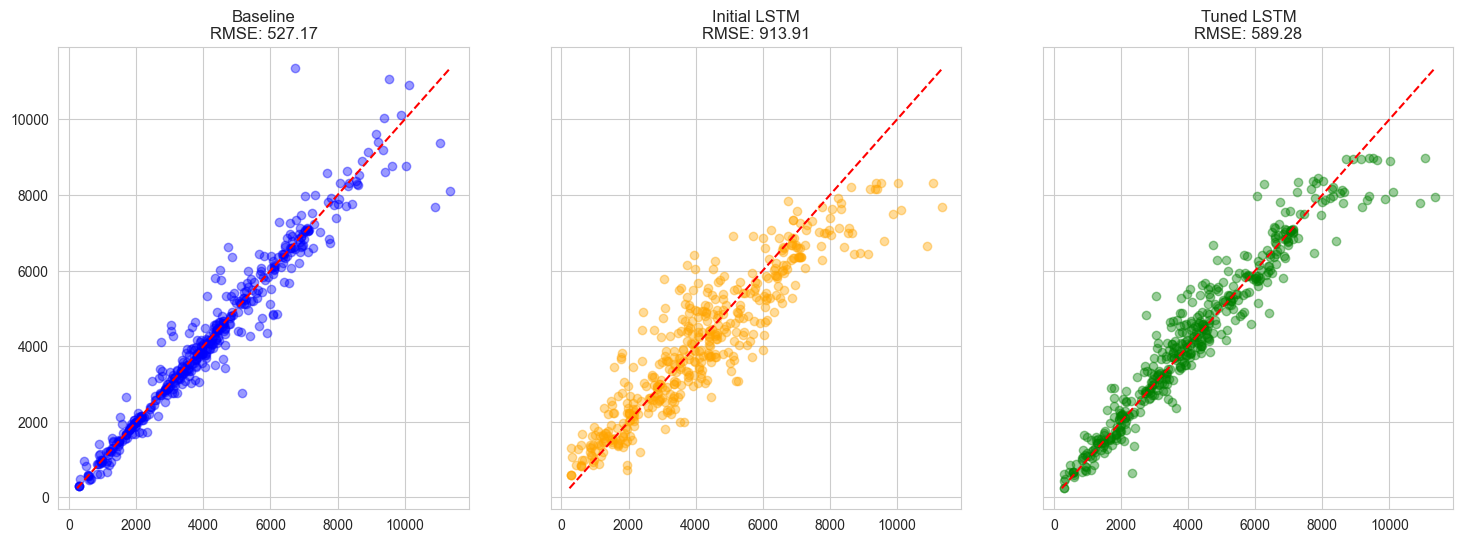

In [20]:
# Calculate Improvement
imp_final = (rmse_baseline - rmse_final) / rmse_baseline * 100

print("--- Final Performance Report (Test Set) ---")
print(f"Baseline Model: RMSE={rmse_baseline:.2f}, R2={r2_baseline:.4f}")
print(f"Initial LSTM:   RMSE={rmse_init:.2f}")
print(f"Tuned LSTM:     RMSE={rmse_final:.2f}, R2={r2_final:.4f} (RMSE Improved {imp_final:.2f}%)")

# --- PLOT ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

y_test_flat = y_test_raw.flatten()
y_pred_init_flat = y_pred_init.flatten()
y_pred_final_flat = y_pred_final.flatten()

min_val = min(y_test_flat.min(), y_pred_clean.min(), y_pred_final_flat.min())
max_val = max(y_test_flat.max(), y_pred_clean.max(), y_pred_final_flat.max())

# 1. Baseline
axes[0].scatter(y_test_clean, y_pred_clean, alpha=0.4, color='blue')
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--')
axes[0].set_title(f'Baseline\nRMSE: {rmse_baseline:.2f}')

# 2. Initial
axes[1].scatter(y_test_flat, y_pred_init_flat, alpha=0.4, color='orange')
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--')
axes[1].set_title(f'Initial LSTM\nRMSE: {rmse_init:.2f}')

# 3. Tuned
axes[2].scatter(y_test_flat, y_pred_final_flat, alpha=0.4, color='green')
axes[2].plot([min_val, max_val], [min_val, max_val], 'r--')
axes[2].set_title(f'Tuned LSTM\nRMSE: {rmse_final:.2f}')

plt.show()

Calculating Permutation Importance (Slow)...


/var/folders/zn/lrmslqwn0g3_slr732tvb0zw0000gn/T/ipykernel_11685/267650415.py:44: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




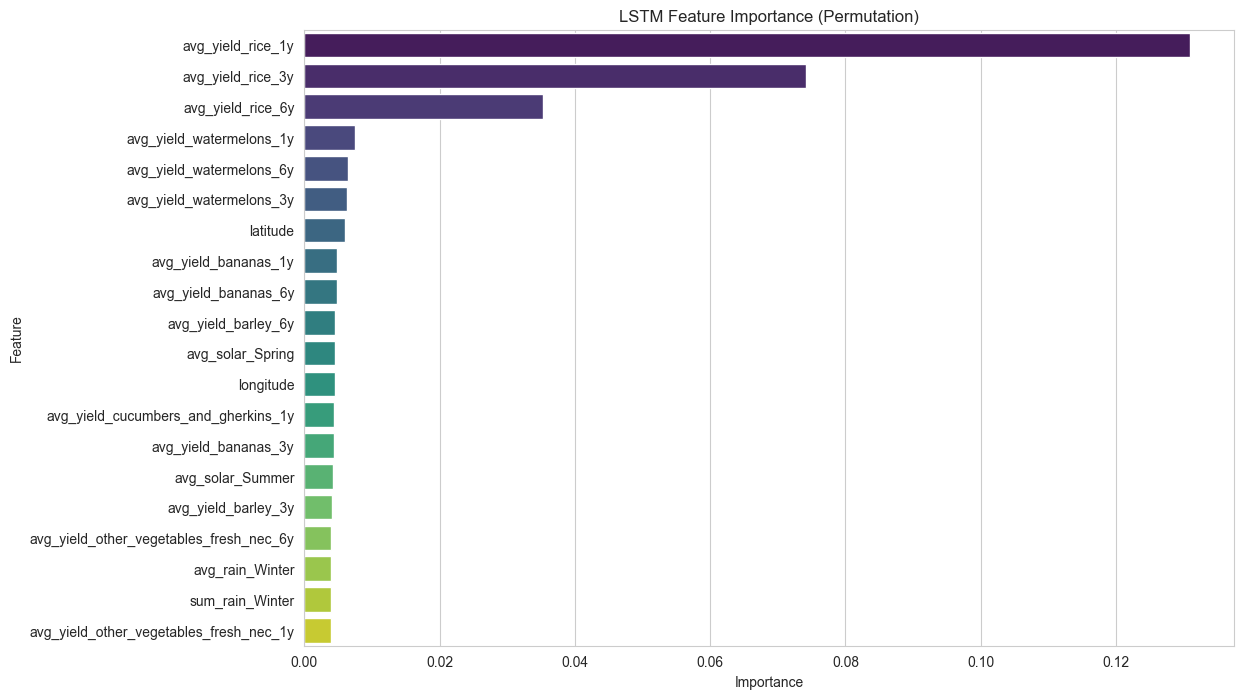

In [21]:
# --- FEATURE IMPORTANCE (Permutation) ---
# LSTM Wrapper for Sklearn Compatibility
class LSTMWrapper:
    def __init__(self, model, device):
        self.model = model
        self.device = device
        
    def predict(self, X):
        # Permutation importance passes 2D numpy arrays
        # We need to convert back to 3D tensors (Batch, 1, Feat)
        self.model.eval()
        with torch.no_grad():
            # Check shape to prevent double unsqueeze if already 3D
            if X.ndim == 2:
                X_3d = X[:, np.newaxis, :]
            else:
                X_3d = X
                
            inputs = torch.tensor(X_3d, dtype=torch.float32).to(self.device)
            preds = self.model(inputs)
        return preds.cpu().numpy().flatten()
    
    # Dummy fit to satisfy sklearn checker
    def fit(self, X, y): return self

wrapped_model = LSTMWrapper(final_model, device)

print("Calculating Permutation Importance (Slow)...")
result = permutation_importance(
    wrapped_model,
    X_test_final_np, # Pass 2D numpy array
    y_test_raw.flatten(),
    n_repeats=5,
    random_state=42,
    scoring='r2'
)

fi_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False).head(20)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=fi_df, palette='viridis')
plt.title('LSTM Feature Importance (Permutation)')
plt.show()